In [52]:
f = open("../../Categories/QuickDraw/quickDraw.txt","r")
classes = f.readlines()
f.close()

In [53]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [3]:
!mkdir Data

In [54]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import randint

In [59]:
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
    
    all_files = glob.glob(os.path.join(root, '*.npy'))
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    
    # Load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0:max_items_per_class, :]
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        class_name, _ = os.path.splitext(os.path.basename(file))
        class_names.append(class_name.replace('full_numpy_bitmap_','').title())
    
    # Randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]
    
    # Split into training and testing
    vfold_size = int(x.shape[0] * vfold_ratio)
    x_test = x[:vfold_size, :]
    y_test = y[:vfold_size]
    x_train = x[vfold_size:, :]
    y_train = y[vfold_size:]
    
    return x_train, y_train, x_test, y_test, class_names

In [60]:
x_train, y_train, x_test, y_test, class_names = load_data(r"../../Data/QuickDraw/")
num_classes = len(class_names)

In [7]:
def preprocess_data(x_train, x_test, y_train, y_test, num_classes, image_size=28):
    
    # Reshape and normalize
    x_train = x_train.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    
    # Convert to categorical
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, x_test, y_train, y_test


In [8]:
x_train, x_test, y_train, y_test = preprocess_data(
        x_train, x_test, y_train, y_test, num_classes
    )

In [9]:
def create_model(input_shape, num_classes):

    model = keras.Sequential([

        layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [10]:
model = create_model(x_train.shape[1:], num_classes)
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         6,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,792 (405.44 KB)

 Trainable params: 103,568 (404.56 KB)

 Non-trainable params: 224 (896.00 B)

In [12]:
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2
        )
    ]

In [27]:
history = model.fit(
        x_train,
        y_train,
        batch_size=256,
        epochs=20,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.8758 - loss: 0.4534 - val_accuracy: 0.8809 - val_loss: 0.4580 - learning_rate: 2.5000e-04
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.8774 - loss: 0.4453 - val_accuracy: 0.8813 - val_loss: 0.4596 - learning_rate: 2.5000e-04
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.8772 - loss: 0.4447 - val_accuracy: 0.8813 - val_loss: 0.4600 - learning_rate: 2.5000e-04
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.8796 - loss: 0.4327 - val_accuracy: 0.8820 - val_loss: 0.4536 - learning_rate: 1.2500e-04
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.8786 - loss: 0.4401 - val_accuracy: 0.8822 - val_loss: 0.4512 - learning_rate: 1.2500e-04
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.8786 - loss: 0.4346 - val_accuracy: 0.8820 - val_loss: 0.4504 - learning_rate: 1.2500e-04
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/ste

In [48]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc*100:.2f}%')


Test accuracy: 88.38%


In [49]:
def plot_sample(x_data, y_true, class_names, title="Sample Image"):
    idx = randint(0, len(x_data))
    plt.figure(figsize=(4, 4))
    plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
    plt.title(f"{title}\nClass: {class_names[int(y_true[idx])]}")
    plt.axis('off')
    plt.show()

In [50]:
def predict_drawing(image, top_k=5):
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        top_indices = (-pred).argsort()[:top_k]
        return [class_names[i] for i in top_indices]

In [51]:
str(class_names)

"['DryingofLeaflet', 'Flaccidity', 'Yellowing']"

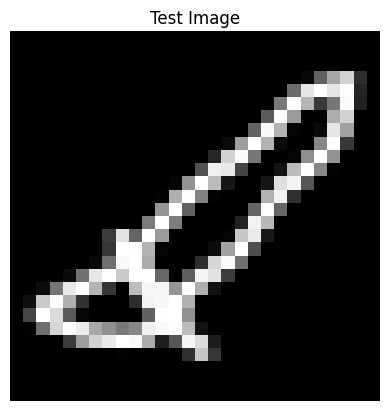

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


IndexError: list index out of range

In [47]:
# Show sample prediction
idx = randint(0, len(x_test))
test_image = x_test[idx]

plt.imshow(test_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title("Test Image")
plt.show()

predictions = predict_drawing(test_image)
print("\nTop 5 predictions:", predictions)


In [26]:
model.save("quickDraw.keras")

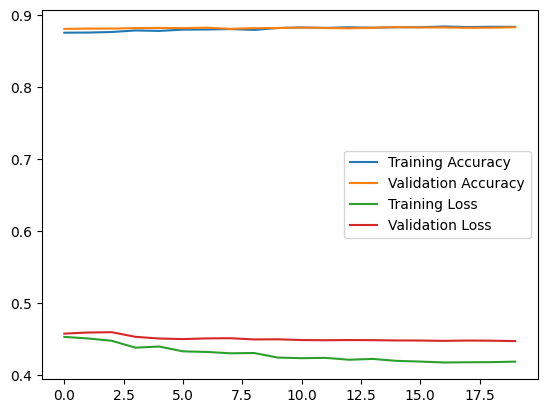

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

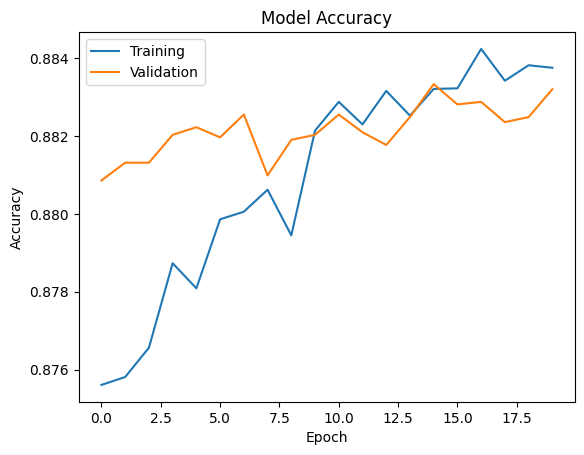

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

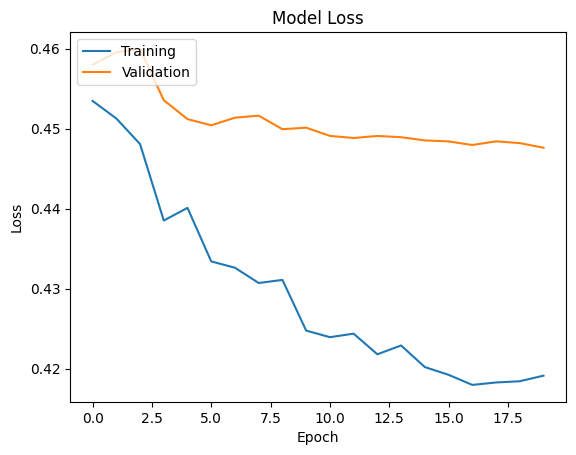

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


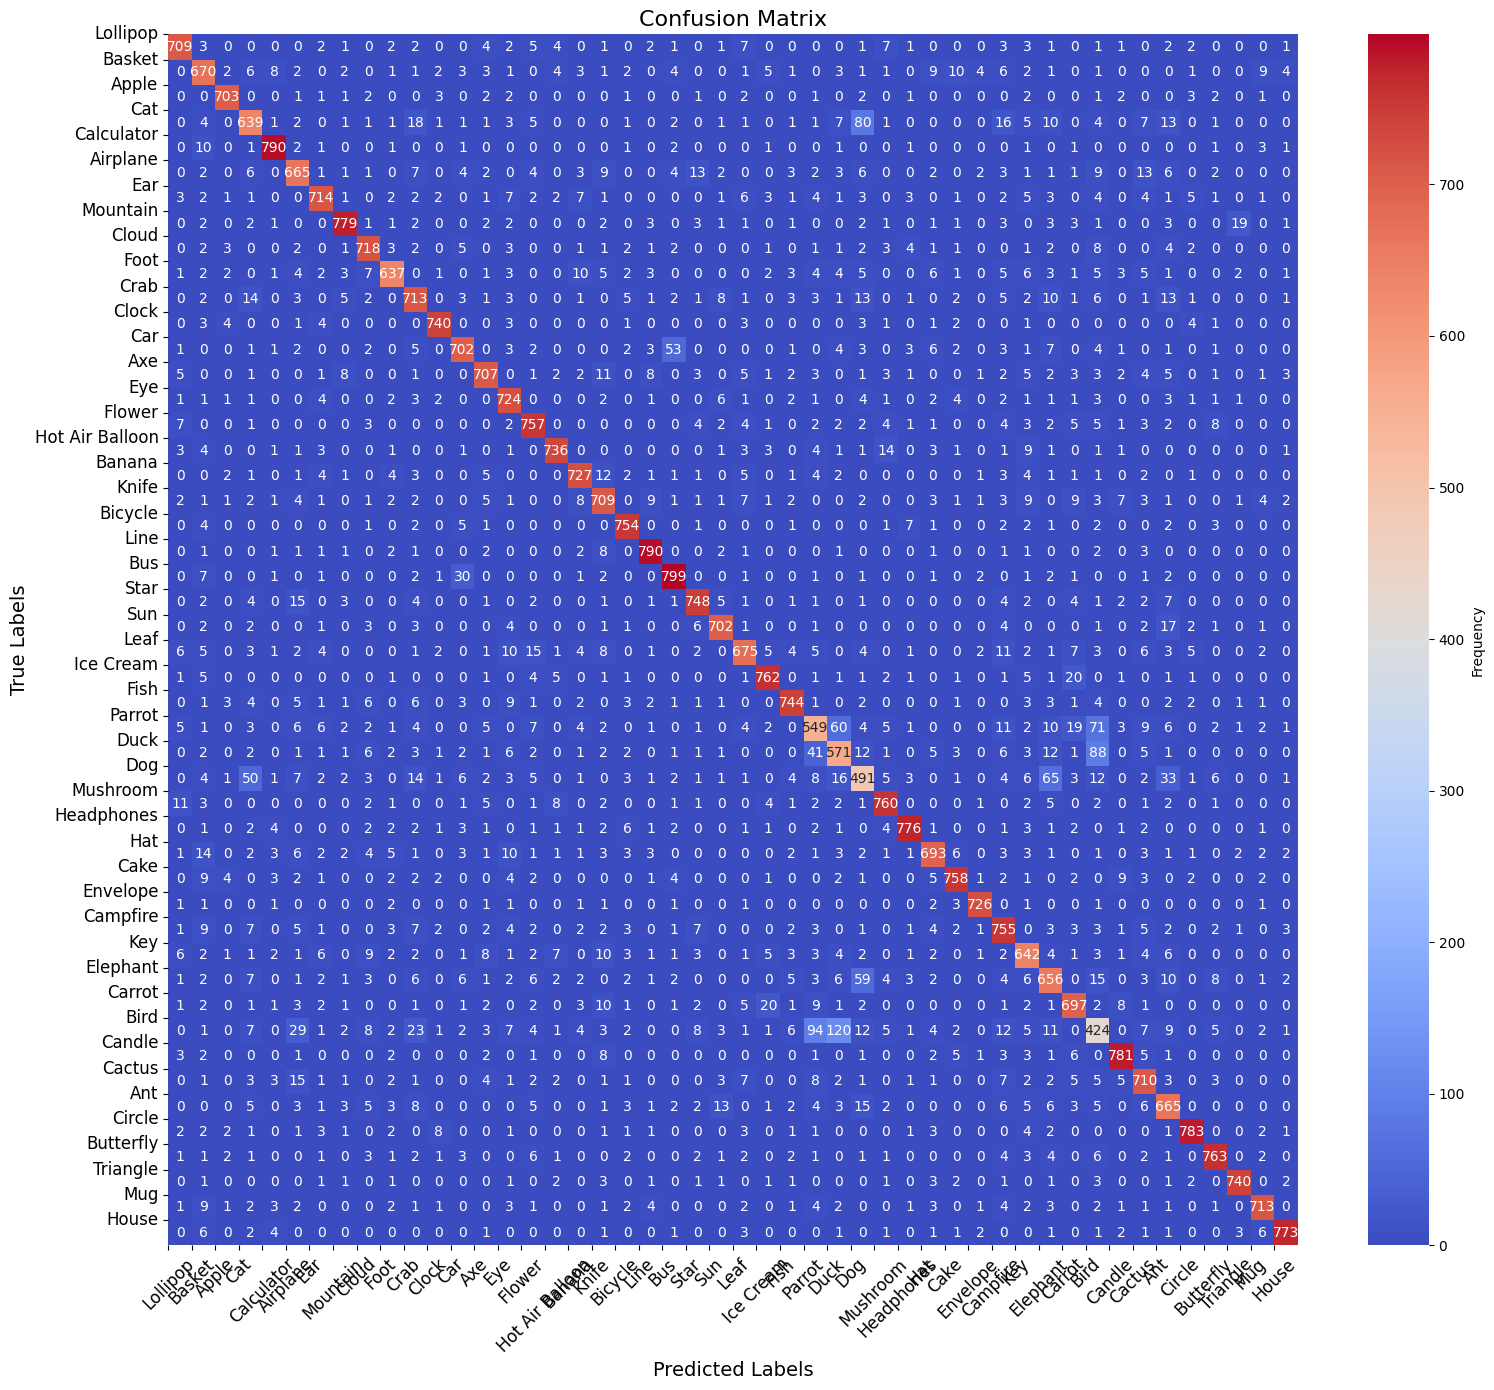

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred_class = model.predict(x_test).argmax(-1)
y_test_class = y_test.argmax(-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(16, 14))  # Increase figure size for clarity
sns.heatmap(
    cm,
    annot=True,          # Show the numbers inside the heatmap cells
    fmt='g',             # Display numbers as integers
    cmap='coolwarm',     # Choose a more color-diverse colormap
    cbar_kws={'label': 'Frequency'}  # Add a label to the color bar
)

# Add axis labels and title
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Add meaningful labels to the x and y axes
x_labels = class_names
y_labels = class_names
plt.xticks(range(len(x_labels)), x_labels, fontsize=12, rotation=45)  # Use class names for x-axis labels
plt.yticks(range(len(y_labels)), y_labels, fontsize=12, rotation=0)  # Use class names for y-axis labels

# Show the improved confusion matrix
plt.tight_layout()
plt.show()
